In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import numpy 

%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

import sys 
sys.path.append('..')
from models_nf import MixedModelDensityEstimator, RealNVPDensityEstimatorLayer

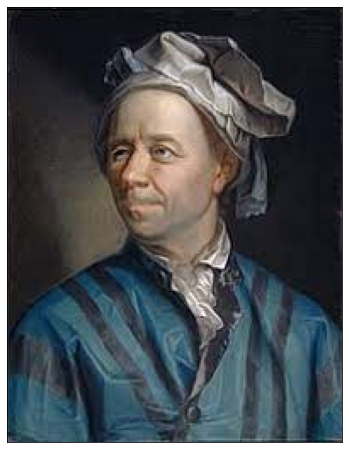

In [2]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

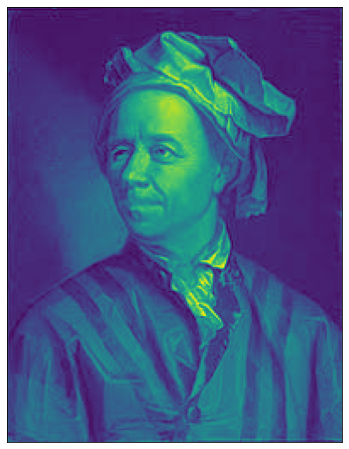

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(grey)

In [13]:
#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 300000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])

C:\Users\EA264728\AppData\Local\Temp\ipykernel_3224\2279585613.py:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


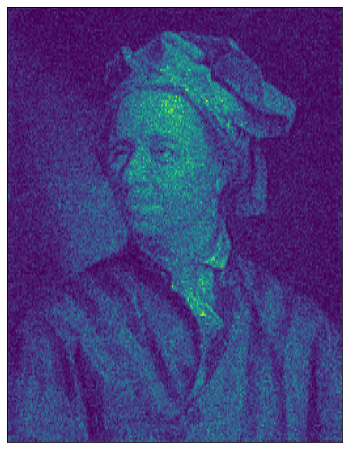

In [14]:
hist_target_samples, x_edges, y_edges = numpy.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, columns],[0,lines]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [27:01<00:00, 16.22s/it, loss = 11.233142852783203]


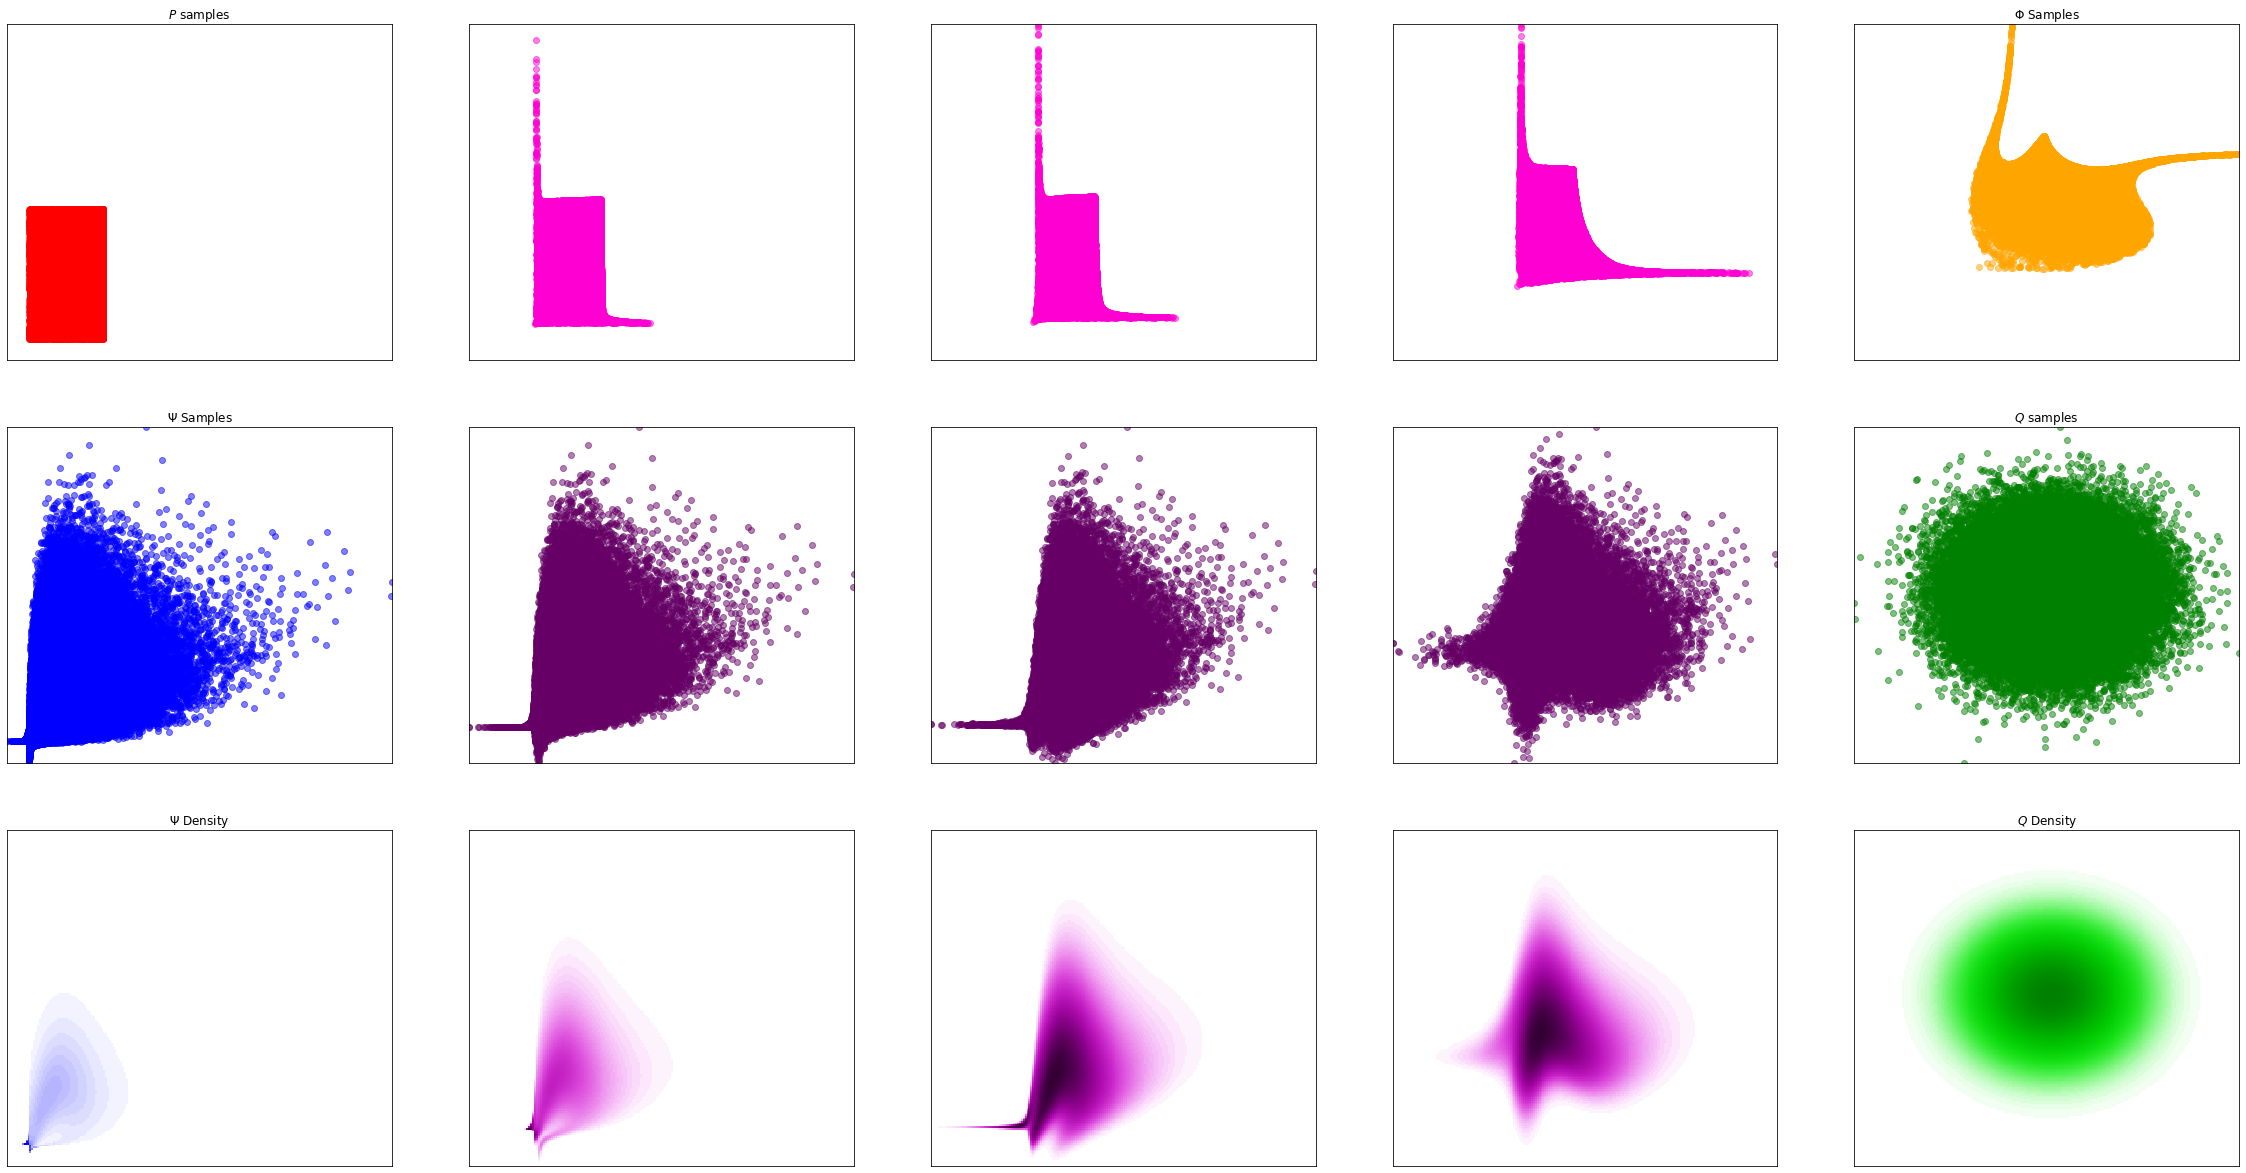

In [15]:
num_samples = target_samples.shape[0]
epochs =100
batch_size = 30000
structure = [[RealNVPDensityEstimatorLayer,[128,128,128]],[RealNVPDensityEstimatorLayer,[128,128,128]],[RealNVPDensityEstimatorLayer,[128,128,128]],[RealNVPDensityEstimatorLayer,[128,128,128]]]
realnvp = MixedModelDensityEstimator(target_samples,structure)
realnvp.train(epochs, batch_size)
realnvp.model_visual(num_samples=int(num_samples/5), flow = True)

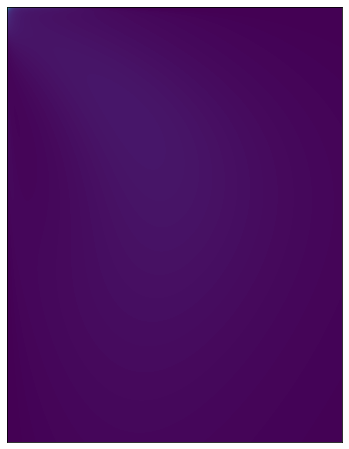

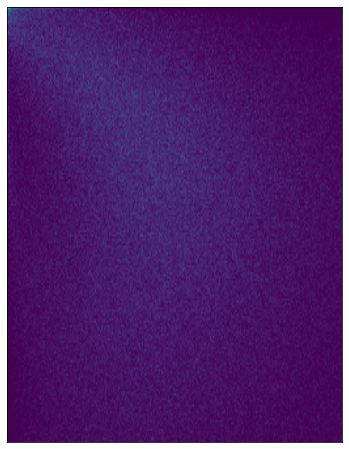

In [16]:
grid = torch.cartesian_prod(torch.linspace(0,lines,2*lines),torch.linspace(0,columns, 2*columns))
density = torch.exp(realnvp.log_density(grid)).reshape(2*lines,2*columns).T.cpu().detach()
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
dif_samples = realnvp.sample_model(target_samples.shape[0])
hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, columns],[0,lines]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])